In [1]:
library(reshape2)
install.packages("ggpubr")
library(ggplot2)
install.packages("pheatmap")
library(pheatmap)
library(ggpubr)
library(RColorBrewer
       )

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

Loading required package: magrittr



In [2]:
### Differential gene expression analysis function

multi_dataset = function(dataset){
names = rownames(dataset)
dataset = apply(dataset, 2, as.character)
dataset = apply(dataset, 2, as.numeric)
rownames(dataset) = names
head(dataset)
  uni = unique(colnames(dataset))
  com = combn(uni, 2, simplify = F)
  print(com)
  for(j in 1:length(com)){
   
    ix = which(colnames(dataset) == com[[j]][1])
   
    ix2 = which( colnames(dataset) == com[[j]][2])
  mat = matrix(NA, nrow(dataset), 6)
for(i in 1:nrow(dataset)){
  if((length(which(dataset[i, ix] > 0)) > 1) & (length(which(dataset[i, ix2] > 0)) > 1)){
  mat[i, 4] = t.test(as.numeric(dataset[i, ix]), as.numeric(dataset[i, ix2]))$p.value
}}
  mat[, 5] = p.adjust(mat[, 4], method = "fdr")
 
mean1 = as.numeric(as.character(apply(dataset[, ix], 1, mean, na.rm = T)))
mean2 = as.numeric(as.character(apply(dataset[, ix2], 1, mean, na.rm = T)))

lfc = log2((mean1+0.00000000001)/(mean2+0.00000000001)+1)
higher = mean1 > mean2

mat[, 1] = mean1
mat[, 2] = mean2
mat[, 3]= lfc
mat[, 6] = higher

colnames(mat) = c("Mean1", "Mean2", "logFC", "pval", "FDR-pval", paste("higher_in_", com[[j]][1], sep = ""))
rownames(mat) = rownames(dataset)
write.csv(mat[order(mat[,4]), ], paste("DE_",com[[j]][1], com[[j]][2], sep = "_" ), quote = F)
}}


In [3]:
### lent heatmap pointer script that is publically available (source: https://stackoverflow.com/questions/52599180/partial-row-labels-heatmap-r)


add.flag <- function(pheatmap,
                     kept.labels,
                     repel.degree) {

  # repel.degree = number within [0, 1], which controls how much 
  #                space to allocate for repelling labels.
  ## repel.degree = 0: spread out labels over existing range of kept labels
  ## repel.degree = 1: spread out labels over the full y-axis

  heatmap <- pheatmap$gtable

  new.label <- heatmap$grobs[[which(heatmap$layout$name == "row_names")]] 

  # keep only labels in kept.labels, replace the rest with ""
  new.label$label <- ifelse(new.label$label %in% kept.labels, 
                            new.label$label, "")

  # calculate evenly spaced out y-axis positions
  repelled.y <- function(d, d.select, k = repel.degree){
    # d = vector of distances for labels
    # d.select = vector of T/F for which labels are significant

    # recursive function to get current label positions
    # (note the unit is "npc" for all components of each distance)
    strip.npc <- function(dd){
      if(!"unit.arithmetic" %in% class(dd)) {
        return(as.numeric(dd))
      }

      d1 <- strip.npc(dd$arg1)
      d2 <- strip.npc(dd$arg2)
      fn <- dd$fname
      return(lazyeval::lazy_eval(paste(d1, fn, d2)))
    }

    full.range <- sapply(seq_along(d), function(i) strip.npc(d[i]))
    selected.range <- sapply(seq_along(d[d.select]), function(i) strip.npc(d[d.select][i]))

    return(unit(seq(from = max(selected.range) + k*(max(full.range) - max(selected.range)),
                    to = min(selected.range) - k*(min(selected.range) - min(full.range)), 
                    length.out = sum(d.select)), 
                "npc"))
  }
  new.y.positions <- repelled.y(new.label$y,
                                d.select = new.label$label != "")
  new.flag <- segmentsGrob(x0 = new.label$x,
                           x1 = new.label$x + unit(0.15, "npc"),
                           y0 = new.label$y[new.label$label != ""],
                           y1 = new.y.positions)

  # shift position for selected labels
  new.label$x <- new.label$x + unit(0.2, "npc")
  new.label$y[new.label$label != ""] <- new.y.positions

  # add flag to heatmap
  heatmap <- gtable::gtable_add_grob(x = heatmap,
                                   grobs = new.flag,
                                   t = 4, 
                                   l = 4
  )

  # replace label positions in heatmap
  heatmap$grobs[[which(heatmap$layout$name == "row_names")]] <- new.label

  # plot result
  grid.newpage()
  grid.draw(heatmap)

  # return a copy of the heatmap invisibly
  invisible(heatmap)
}

In [4]:
download.file("https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-PAAD.htseq_fpkm-uq.tsv.gz", "PDAC.tsv.gz"
      )

In [5]:
temp = read.csv(gzfile("PDAC.tsv.gz"), header= T, stringsAsFactors =F, row.names = 1, check.names =F, sep = "\t")

In [7]:
head(temp)

,TCGA-3A-A9IO-01A,TCGA-Z5-AAPL-01A,TCGA-HZ-A49H-01A,TCGA-FB-A4P5-01A,TCGA-FB-AAPS-01A,TCGA-IB-AAUQ-01A,TCGA-HV-A5A5-01A,TCGA-H6-A45N-11A,TCGA-H6-8124-01A,TCGA-IB-7654-01A,⋯,TCGA-IB-7890-01A,TCGA-LB-A9Q5-01A,TCGA-HZ-7924-01A,TCGA-HZ-8002-01A,TCGA-FB-AAPY-01A,TCGA-F2-A44H-01A,TCGA-IB-A5SO-01A,TCGA-FB-AAQ3-01A,TCGA-FB-AAPZ-01A,TCGA-H8-A6C1-01A
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000242268.2,17.04565,9.693558,0.000000,11.023359,10.923589,13.138818,12.842791,9.767561,9.199465,0.000000,⋯,0.000000,10.38100,8.473095,10.56451,9.613139,0.000000,12.088945,0.00000,11.06880,0.000000
ENSG00000270112.3,0.00000,8.431555,6.799139,8.178247,7.084111,7.973076,8.826444,6.928391,0.000000,7.986015,⋯,8.734172,0.00000,7.947407,0.00000,6.775121,7.847837,6.258179,0.00000,0.00000,6.701456
ENSG00000167578.15,17.72522,17.095601,16.887146,17.014995,16.998546,16.500358,16.750299,17.723066,16.333151,15.895757,⋯,15.337835,16.23066,15.625386,15.21133,17.595424,16.849131,16.675413,17.28658,16.29042,17.129134
ENSG00000273842.1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,⋯,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
ENSG00000078237.5,17.06160,16.376529,16.452349,16.460069,16.080704,15.965067,16.428086,16.337610,15.691909,18.809419,⋯,16.316664,16.18467,16.302285,16.46972,16.098655,16.092752,16.086007,16.24466,16.48188,16.469228
ENSG00000146083.10,17.44111,18.918192,17.195220,17.800900,17.666034,17.921830,17.868207,19.671673,18.058529,18.881084,⋯,17.795954,17.51043,17.812304,17.37869,18.018869,17.907951,18.186464,17.02037,18.42084,18.299834


In [8]:
### Molecular classifications according Bailey's scheme is retrieved from Rapheal et al 2017. 

### the groups are created on cbioportal's server and could be accessed using this link (https://www.cbioportal.org/comparison?comparisonId=601f6b2ee4b015b63e9d951a)

groups = read.csv("overlap.txt", header= T, stringsAsFactors = F, row.names = 1, check.names = F, sep = "\t")
groups = groups[, -c(1,2)]
mDF = melt(as.matrix(groups))
idx = which(mDF[,3] == "Yes")
groups = data.frame(group = mDF[idx,2], row.names =mDF[idx,1])
head(groups)

,group
,<fct>
TCGA-2J-AAB9-01,adex
TCGA-2J-AABO-01,adex
TCGA-2J-AABR-01,adex
TCGA-2J-AABV-01,adex
TCGA-3A-A9I5-01,adex
TCGA-3A-A9I9-01,adex


In [13]:
### intersect samples from expression data and the groups
colnames(temp) = substr(colnames(temp), 1, 15)
int = intersect(rownames(groups), colnames(temp))
temp = temp[, int]


,TCGA-2J-AAB9-01,TCGA-2J-AABO-01,TCGA-2J-AABR-01,TCGA-2J-AABV-01,TCGA-3A-A9I5-01,TCGA-3A-A9I9-01,TCGA-3A-A9IX-01,TCGA-3E-AAAY-01,TCGA-F2-A44H-01,TCGA-F2-A7TX-01,⋯,TCGA-IB-8127-01,TCGA-IB-A5SS-01,TCGA-IB-A6UF-01,TCGA-IB-A7LX-01,TCGA-IB-A7M4-01,TCGA-IB-AAUO-01,TCGA-IB-AAUQ-01,TCGA-S4-A8RO-01,TCGA-XD-AAUL-01,TCGA-YH-A8SY-01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000242268.2,0.00000,12.214093,10.812001,0.00000,14.448691,0.000000,0.000000,9.420932,0.000000,0.00000,⋯,8.413195,9.170795,9.436240,0.000000,0.00000,9.461220,13.138818,11.521534,10.24960,0.00000
ENSG00000270112.3,0.00000,8.368753,6.973318,0.00000,9.542262,7.822768,6.341798,6.584530,7.847837,0.00000,⋯,5.589820,0.000000,6.599701,6.504946,0.00000,6.624462,7.973076,8.675169,0.00000,0.00000
ENSG00000167578.15,16.38902,18.706206,16.182362,16.77738,17.368372,17.764446,15.781612,16.917737,16.849131,16.39056,⋯,16.279843,15.394085,16.344510,16.384861,16.34282,17.418427,16.500358,16.369526,17.57244,16.91302
ENSG00000273842.1,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,⋯,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000
ENSG00000078237.5,16.33887,16.742098,16.361370,16.44103,16.836226,16.350504,16.285360,16.229621,16.092752,16.83486,⋯,16.850260,16.354341,15.030609,17.079608,16.08081,16.715609,15.965067,16.704762,16.16957,16.57614
ENSG00000146083.10,18.01464,17.606903,18.089505,16.71792,17.684848,18.100290,18.005745,17.889997,17.907951,18.17737,⋯,18.179129,17.943222,18.267386,18.257485,18.21009,18.478285,17.921830,18.183902,17.96689,17.88442


In [14]:
## convert gene ids to names (using biomart annotations) and only considering genes with expression > 0 in atleast 10 samples

mart = read.table("mart_export.txt", header = T, stringsAsFactors =F, row.names = 1, sep = "\t")
rownames(temp) = gsub("[.][0-9]+$", "", rownames(temp))
names = mart[rownames(temp), 1]
temp = as.matrix(temp)
rownames(temp) = names
head(temp)
ctx = rowSums(temp > 0) > 10
temp2 = temp
temp = temp[ctx, ]




,TCGA-2J-AAB9-01,TCGA-2J-AABO-01,TCGA-2J-AABR-01,TCGA-2J-AABV-01,TCGA-3A-A9I5-01,TCGA-3A-A9I9-01,TCGA-3A-A9IX-01,TCGA-3E-AAAY-01,TCGA-F2-A44H-01,TCGA-F2-A7TX-01,⋯,TCGA-IB-8127-01,TCGA-IB-A5SS-01,TCGA-IB-A6UF-01,TCGA-IB-A7LX-01,TCGA-IB-A7M4-01,TCGA-IB-AAUO-01,TCGA-IB-AAUQ-01,TCGA-S4-A8RO-01,TCGA-XD-AAUL-01,TCGA-YH-A8SY-01
LINC02082,0.00000,12.214093,10.812001,0.00000,14.448691,0.000000,0.000000,9.420932,0.000000,0.00000,⋯,8.413195,9.170795,9.436240,0.000000,0.00000,9.461220,13.138818,11.521534,10.24960,0.00000
AC090241.2,0.00000,8.368753,6.973318,0.00000,9.542262,7.822768,6.341798,6.584530,7.847837,0.00000,⋯,5.589820,0.000000,6.599701,6.504946,0.00000,6.624462,7.973076,8.675169,0.00000,0.00000
RAB4B,16.38902,18.706206,16.182362,16.77738,17.368372,17.764446,15.781612,16.917737,16.849131,16.39056,⋯,16.279843,15.394085,16.344510,16.384861,16.34282,17.418427,16.500358,16.369526,17.57244,16.91302
NA,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,⋯,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000
TIGAR,16.33887,16.742098,16.361370,16.44103,16.836226,16.350504,16.285360,16.229621,16.092752,16.83486,⋯,16.850260,16.354341,15.030609,17.079608,16.08081,16.715609,15.965067,16.704762,16.16957,16.57614
RNF44,18.01464,17.606903,18.089505,16.71792,17.684848,18.100290,18.005745,17.889997,17.907951,18.17737,⋯,18.179129,17.943222,18.267386,18.257485,18.21009,18.478285,17.921830,18.183902,17.96689,17.88442


In [26]:
new_at[grep("progenitor", new_at[,7]),]
grep("MUC16", sq[,1])

,X,Mean1,Mean2,logFC,pval,FDR.pval,Higher in
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1299,CAPN5,18.47174,19.93200,0.9461602,4.250584e-29,1.875230e-24,progenitor
2152,TJP3,17.92659,19.40597,0.9439341,2.649999e-27,5.845501e-23,progenitor
3175,SPIRE2,15.43039,17.21607,0.9231709,1.737512e-25,2.555128e-21,progenitor
4129,USH1C,17.85916,19.39351,0.9417699,1.665599e-23,1.837031e-19,progenitor
5104,EPS8L3,18.30789,20.28771,0.9278302,2.601739e-23,2.295618e-19,progenitor
6139,FAM83E,17.98028,19.62120,0.9383762,5.060846e-23,3.721155e-19,progenitor
7109,GPR35,16.58219,18.04230,0.9404097,2.128592e-22,1.341530e-18,progenitor
8107,CAPN8,18.07715,20.21996,0.9214556,6.555708e-22,3.615227e-18,progenitor
9105,PLA2G10,15.46904,17.60649,0.9096569,2.075994e-21,9.505893e-18,progenitor


[1] 418

In [15]:
### Run differential expression analysis betweeen the groups (each group against all others)

id = unique(groups[,1])
for(i in 1:length(id)){
    dataset =temp
    colnames(dataset) = groups[colnames(dataset), 1]
    ix  = which(colnames(dataset) == id[i])
    colnames(dataset)[-ix] = "11_Others"
    multi_dataset(dataset)}

[[1]]
[1] "adex"      "11_Others"

[[1]]
[1] "11_Others"   "immunogenic"

[[1]]
[1] "11_Others"  "progenitor"

[[1]]
[1] "11_Others" "Squamous" 



In [50]:
### process differentially expressed gene list

files = list.files(pattern = "11_Others")
nam = gsub("DE__11_", "", files)
nam = gsub("Others", "", nam)
nam = gsub("_", "", nam)
at = read.csv(files[4], stringsAsFactors = F, header = T )
id = which(at[,7] == 1)
id2 = which(at[,6] < 0.05)
int = intersect(id, id2)
at = at[int, ]
at[,7] = nam[1]
colnames(at)[7] = "Higher in"
for(i in seq(1, 3)){
    at2 = read.csv(files[i], stringsAsFactors = F, header = T)
    idd = which(at2[, 7] == 0)
    idd2 = which(at2[, 6] <  0.05)
    int2 = intersect(idd, idd2)
    at2 = at2[int2, ]
    at2[,7] = nam[i]
    colnames(at2)[7] = "Higher in"

    at = rbind(at, at2)}
new_at = at[-which(is.na(at[,1])),]
head(new_at)
dim(new_at)

,X,Mean1,Mean2,logFC,pval,FDR.pval,Higher in
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,REG3A,24.98181,17.037042,1.302362,5.862140e-30,1.563808e-25,immunogenic
2,REG1CP,17.90311,7.252149,1.794380,7.172279e-30,1.563808e-25,immunogenic
3,PNLIPRP1,20.51061,11.427667,1.482756,5.607102e-29,8.150297e-25,immunogenic
4,CTRB2,24.46426,15.075094,1.391122,3.229467e-28,3.520684e-24,immunogenic
5,CPA2,23.93472,14.865890,1.384073,1.429222e-27,1.246482e-23,immunogenic
6,CELA3A,25.67469,16.234447,1.368207,2.780860e-27,2.021082e-23,immunogenic


[1] 19252     7

In [57]:
## select top 500 genes from each group and filtering out the NA producing genes 
new_at = new_at[order(new_at[, 6]), ]
c = c()
for(i in 1:length(nam)){
   ic =  grep(nam[i], new_at[,7])
    c = append(c, ic[1:500])
    }
names = new_at[c, 1]
dataset = temp
lt = scale(log2(t(dataset[na.omit(names), ])+1))
revised_names = rownames(na.omit(t(lt)))

### sample annotations
sampleinfo = data.frame(group = groups[colnames(temp), ], row.names =colnames(temp))

In [ ]:
### ordering the groups based on clusters

new_t = temp
colnames(new_t) = groups[colnames(new_t), 1]
uni = unique(colnames(new_t))
new_t = new_t[revised_names, ]
lis = c()
for(i in 1:length(uni)){
    id = grep(uni[i], colnames(new_t))
    r = hclust(dist(t(new_t[, id])))
    lis = append(lis, id[r$order])
    }

In [84]:
cols = c("white", "white", "white", brewer.pal(5, "Reds"))

In [ ]:
genes = c('CGB7','MET','MUC15','MUC1','MUC13','MUC3A','MUC5AC','MUC16','KRT7','KRT9','KRT19','KRT6A','KRT16','KRT5','KRT17','KRT14','CFTR','KLF15','KLF13','KLF5','KLF7')

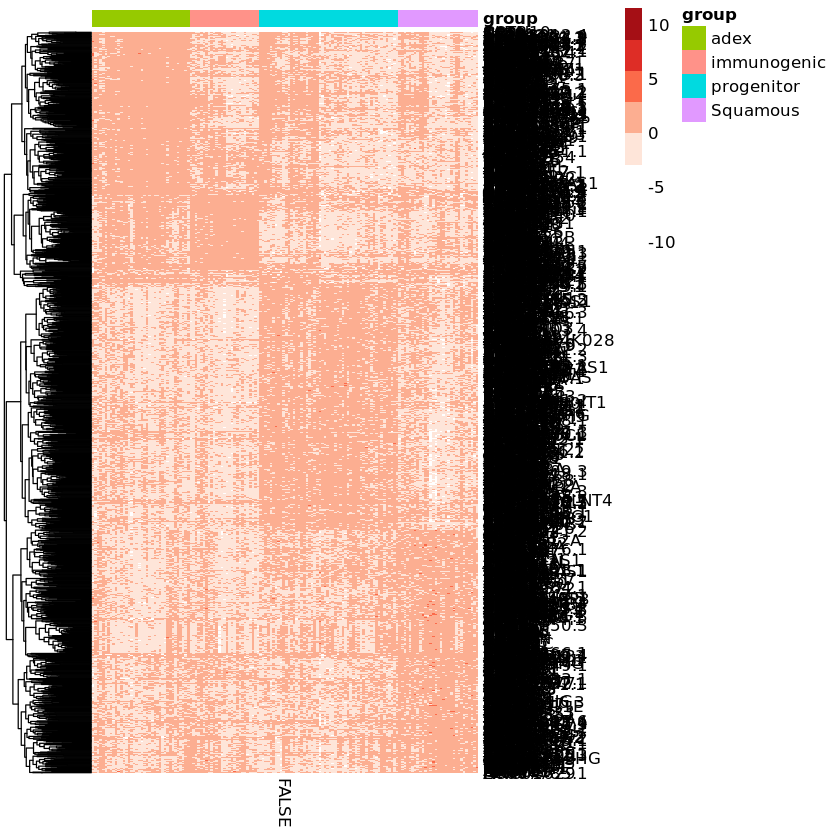

In [141]:
p = pheatmap(log2(dataset[revised_names, lis]+1), scale ="row", annotation_col = sampleinfo, cluster_cols = F, labels_col = F, color = cols)

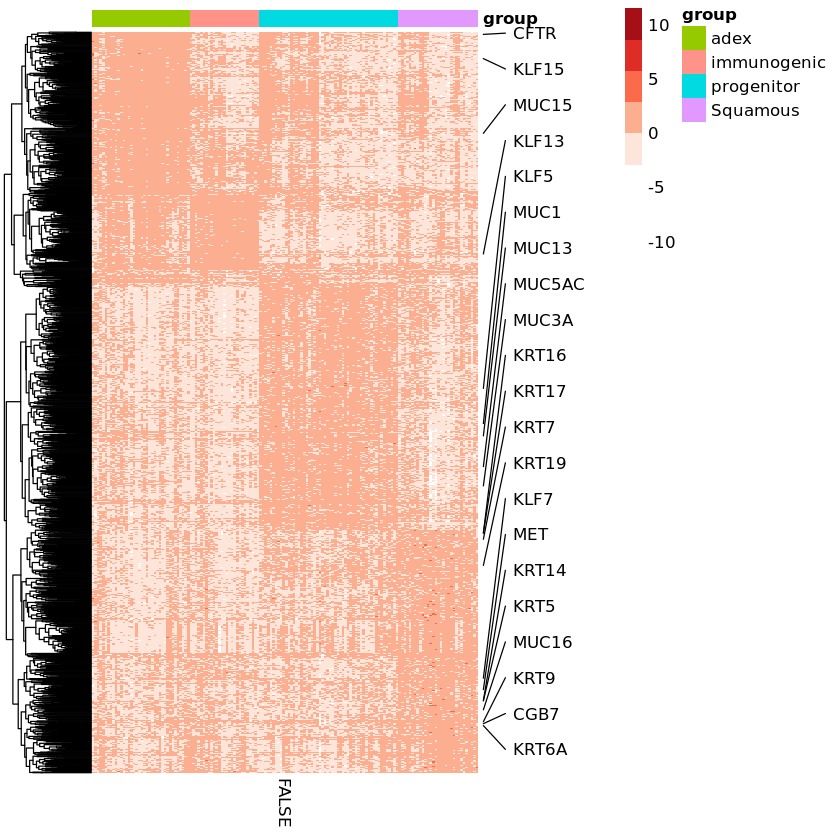

In [146]:
add.flag(p,
         kept.labels = genes,
         repel.degree = 0.50)

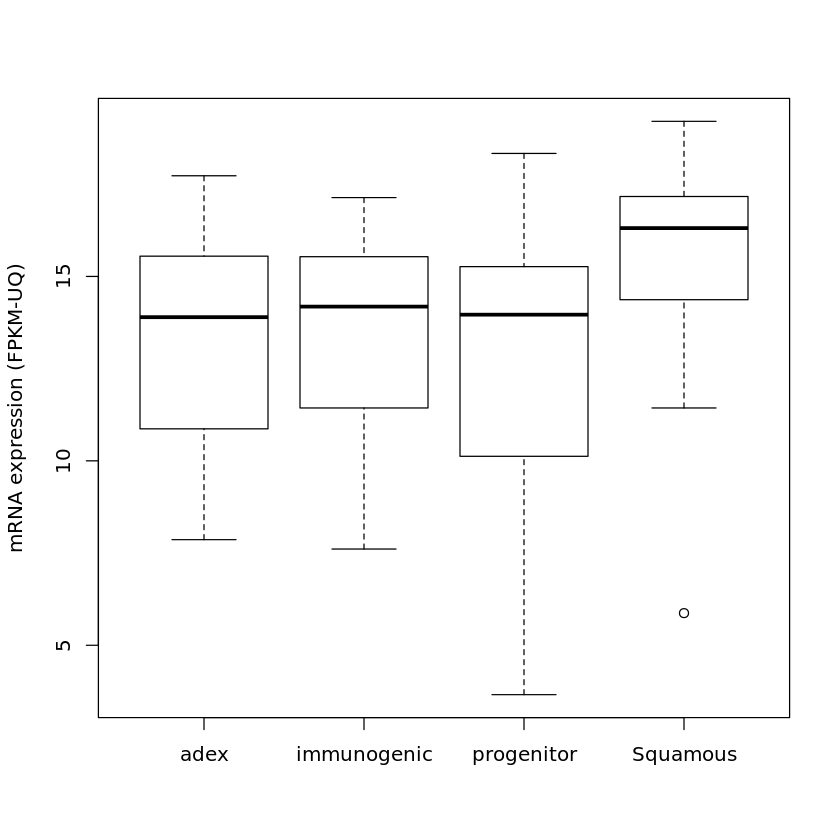

In [148]:
### MUC16 boxplot 

boxplot(new_t["MUC16", ]~colnames(new_t), ylab = "mRNA expression (FPKM-UQ)", xlab = "")